In [383]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from datetime import datetime

In [384]:
torch.manual_seed(42)

## Experimental

In [385]:
class LeNet5AutoEncoder(nn.Module):

    def __init__(self, latent_size=5):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.feature_compressor = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=latent_size*2)
        )
        
        self.feature_expander = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=120),
            nn.Tanh()
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=120, out_channels=16, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5, stride=1)
        )
    
    def encode(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # this is just the technical tensor reshaping. The *actual* flattening is the last 
                                # layer of the feature_extractor, which uses convolution to take the 5x5 feature maps into a single 1x1 value.
        logits = self.feature_compressor(x)
        return logits, probabilities
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.feature_expander(z)
        z = z.unsqueeze(2).unsqueeze(2) # Changing structure: flat->channels. Required for ConvTranspose
        return self.deconv(z)
    
    def forward(self, x):
        mu_and_logvar = self.encode(x).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar
    
    


In [386]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
NoiseTransform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

## NN Utilities

In [387]:
def plot_losses_over_epochs(train_losses: list[float], valid_losses: list[float]):
    '''
    Graphically show the training and validation loss for each epoch.
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [388]:
def run_single_epoch(loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class = 1, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() 
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, Y_true in loader:
        X = normalize_input_fn(X) # Normalizing the input if necessary
        # Y_true = normalize_labels_fn(Y_true)
        # Y_true[Y_true == positive_class]  = 1 # We "normalize" the label of the positive class to be "1". Makes our lives easier (see comment below)
        
        optimizer.zero_grad() if train else None
        
        # Forward pass
        Y_logits, Y_prob = model(X)
        _, predicted_labels = torch.max(Y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in.
                                                        # This actually returns the indices of the highest prediction for each row, 
                                                        # but since the index is one-to-one with the predicted digit (i.e., 0 or 1), 
                                                        # we use the index of the max probability as the label that's being predicted
        batch_loss = criterion(Y_logits, Y_true)
        running_loss += batch_loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            batch_loss.backward()
            optimizer.step()
    
    avg_batch_loss_for_epoch = running_loss / len(loader.dataset)
    return model, optimizer, avg_batch_loss_for_epoch

In [389]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, positive_class=1, num_epochs=10, normalize_input_fn=lambda x: x, 
             normalize_labels_fn=lambda y: y, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}\t')
        
        # Training the model
        _, _, train_loss = run_single_epoch(train_loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class)
        train_losses.append(train_loss)
        
        # Validation
        with torch.no_grad():
            _, _, validation_loss = run_single_epoch(validation_loader, criterion, model, None, normalize_input_fn, normalize_labels_fn, positive_class, False)
            validation_losses.append(validation_loss)
        
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Vaildation loss: {validation_loss:.4f}\t')
    
    print(F"Train losses: {train_losses}")
    print(F"Test losses: {validation_losses}")
    plot_losses_over_epochs(train_losses, validation_losses)
        
    return model, optimizer, (train_losses, validation_losses)

### LeNet5 Model

In [390]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


In [412]:
class SimpleDataSet(Dataset):
    def __init__(self, data, targets):
        super(SimpleDataSet, self).__init__()
        assert data.shape[0] == targets.shape[0] # assuming shape[0] = dataset size
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index].item()

#### Training

In [439]:
def train_model(model, train_loader, test_loader):
    SEED = 42
    LEARNING_RATE = 1e-3
    N_CLASSES = 2

    torch.manual_seed(SEED)
    lenet5 = LeNet5(N_CLASSES)
    optimizer = torch.optim.Adam(lenet5.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    return run_loop(train_loader, test_loader, criterion, model, optimizer, normalize_input_fn=lambda x: x / 255.0)

In [440]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        super(ConcatDataset, self).__init__()
        self.datasetA = datasetA
        self.datasetB = datasetB

    def __getitem__(self, i):
        if i<len(self.datasetA):
            return self.datasetA[i]
        else:
            return self.datasetB[i-len(self.datasetA)]

    def __len__(self):
        return (len(self.datasetA) + len(self.datasetB))

In [394]:
import copy

def get_synthetic_h0_h1(training_set, test_set):
    
    k = math.floor(len(training_set) / 2) # TODO sample random k instead?
    original_training_data = training_set.data
    original_training_targets = training_set.targets

    # Create H0 set
    h0_data = torch.clone(original_training_data[:k]).detach()
    h0_targets = torch.clone(original_training_targets[:k]).detach()

    h0_set = SimpleDataSet(h0_data, h0_targets)
    
    # Create H1 and H1_true set
    h1_0_data = torch.clone(original_training_data[k:]).detach()
    h1_0_targets = torch.clone(original_training_targets[k:]).detach()
    h1_0_targets[:] = 1
    
    h1_0_data_for_true_targetst = torch.clone(original_training_data[k:]).detach()
    h1_0_true_targets = torch.clone(original_training_targets[k:]).detach()
    
    original_test_data = test_set.data
    original_test_targets = test_set.targets
    h1_1_data = torch.clone(original_test_data).detach()
    h1_1_targets = torch.clone(original_test_targets).detach()
    h1_1_targets[:] = 1
    
    h1_1_data_for_true_targets = torch.clone(original_test_data).detach()
    h1_1_true_targets = torch.clone(original_test_targets).detach()
    
    h1_data = torch.cat((h1_0_data, h1_1_data), 0)
    h1_targets = torch.cat((h1_0_targets, h1_1_targets), 0)
    
    h1_set = SimpleDataSet(h1_data, h1_targets)
    
    h1_data_true = torch.cat((h1_0_data_for_true_targetst, h1_1_data_for_true_targets), 0)
    h1_targets_true = torch.cat((h1_0_true_targets, h1_1_true_targets), 0)
    
    h1_set_with_true_targets = SimpleDataSet(h1_data_true, h1_targets_true)
    
    return h0_set, h1_set, h1_set_with_true_targets, k

In [441]:
BATCH_SIZE = 32

def run_discovery(training_set, test_set, score_model, ae=None, alpha=0.1):
    print("--------- Discovery Started ---------")
    
    train_autoencoder(ae, training_set) if ae is not None else 0 
        
    # Train the classifier
    # h0_set, h1_set, h1_set_with_true_targets, k = get_synthetic_h0_h1(training_set, test_set)
    # print(F"Training set size: {len(training_set)}, Test set size: {len(test_set)}")
    # print(F"Selected K: {k}, h0 size: {len(h0_set)} , h1 size: {len(h1_set)}")
    # h0h1_set = ConcatDataset(h0_set,h1_set)
    # h0h1_loader = DataLoader(h0h1_set, batch_size=BATCH_SIZE, shuffle=True)
    train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    train_model(score_model, train_loader, test_loader)
    
    # Got a trained model, let's get the scores
    with torch.no_grad():
        score_model.eval()
        _, probability_scores = score_model(h1_set) # probability scores is a tensor of pairs (p(0), p(1)).
    probability_of_discovery = probability_scores[:,1].numpy() # We only care about the probability of a discovery (p(1))
    scores_df = pd.DataFrame({'score': probability_of_discovery, 'is_test': h1_set.targets.numpy(),'truth':h1_set_with_true_targets.targets.numpy()})
    scores_df.sort_values(by=['score'], inplace=True, ascending=False)
    
    # Use BoNuS and Knockoff counting for stating discoveries while keeping FDR
    fdp = 10 # a value which is definitely bigger than alpha
    l = len(training_set)-k
    m = len(test_set)
    
    for lower_bound in range(len(h1_set)):
        scores_window_df = scores_df[lower_bound:] # get the subset of the samples we want to test with.
        ktest = scores_window_df[scores_window_df['is_test']==1].counts() # This is the "moving" k, which changes as we move the lower score bound.
        v = scores_window_df[scores_window_df['is_test']==0].counts() # The count of false discoveries that we know if (i.e., training samples)
        fdp = (v+1 / l+1) * (m / ktest)
        if fdp<=alpha:
            print(F"Got FDP of {fdp} < alpha({alpha}) , for lower bound: {lower_bound}")
            break;
    
    total_elements = scores_window_df.counts()
    total_discoveries = ktest
    false_discoveries = scores_window_df[scores_window_df['is_test']==1 & scores_window_df['truth']==0].counts()
    print(F"Total elements in window: {total_elements}")
    print(F"Total discoveries in window: {ktest}")
    print(F"False discoveries: {false_discoveries}")
    
    return dict(total_elements=total_elements, total_discoveries=total_discoveries, false_discoveries=false_discoveries)
    
    

#### Getting the MNIST data in LeNet5 compatible form, and creating loaders

In [433]:
# def get_datasets_for_discovery(is_noisy=False):
#     '''
#     Returns: 
#         a tuple of (training Subset, test Subset)
#     '''
#     if not is_noisy:
#         image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
        
#     # Get data of 4, then set the targets as "0" (as this is our "null" class).
#     training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
#     training_four_index = (training_set_full.targets == 4).nonzero().reshape(-1)
#     train_four_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_four_index))
#     train_four_data, train_four_targets = next(iter(train_four_loader))
#     train_four_targets[:] = 0
    
#     training_set = SimpleDataSet(train_four_data, train_four_targets)
    
#     test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    
#     test_four_index = (test_set_full.targets == 4).nonzero().reshape(-1)
#     test_four_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_four_index))
#     test_four_data, test_four_targets = next(iter(test_four_loader))
#     test_four_targets[:] = 0
#     test_nine_index = (test_set_full.targets == 9).nonzero().reshape(-1)
#     test_nine_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_nine_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_nine_index))
#     test_nine_data, test_nine_targets = next(iter(test_nine_loader))
#     test_nine_targets[:] = 1
    
#     test_data = torch.cat((test_four_data, test_nine_data), 0)
#     test_targets = torch.cat((test_four_targets, test_nine_targets), 0)
#     test_set = SimpleDataSet(test_data, test_targets)
    
#     return training_set, test_set

In [434]:
def get_datasets_for_discovery(is_noisy=False):
    '''
    Returns: 
        a tuple of (training Subset, test Subset)
    '''
    if not is_noisy:
        image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
        
    # Get data of 4, then set the targets as "0" (as this is our "null" class).
    training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
    training_four_index = torch.logical_or(training_set_full.targets == 4, training_set_full.targets == 9).nonzero().reshape(-1)
    train_four_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_four_index))
    train_four_data, train_four_targets = next(iter(train_four_loader))
    train_four_targets[(train_four_targets==4).nonzero().reshape(-1)] = 0
    train_four_targets[(train_four_targets==9).nonzero().reshape(-1)] = 1
    
    training_set = SimpleDataSet(train_four_data, train_four_targets)
    
    test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    test_four_index = torch.logical_or(test_set_full.targets == 4, test_set_full.targets == 9).nonzero().reshape(-1)
    test_four_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_four_index))
    test_four_data, test_four_targets = next(iter(test_four_loader))
    test_four_targets[(test_four_targets==4).nonzero().reshape(-1)] = 0
    test_four_targets[(test_four_targets==9).nonzero().reshape(-1)] = 1
    test_set = SimpleDataSet(test_four_data, test_four_targets)
    
    return training_set, test_set

--------- Discovery Started ---------
Epoch: 0	
18:39:15 --- Epoch: 0	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 1	
18:39:17 --- Epoch: 1	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 2	
18:39:20 --- Epoch: 2	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 3	
18:39:23 --- Epoch: 3	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 4	
18:39:26 --- Epoch: 4	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 5	
18:39:29 --- Epoch: 5	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 6	
18:39:32 --- Epoch: 6	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 7	
18:39:36 --- Epoch: 7	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 8	
18:39:39 --- Epoch: 8	Train loss: 0.6933	Vaildation loss: 0.6932	
Epoch: 9	
18:39:42 --- Epoch: 9	Train loss: 0.6933	Vaildation loss: 0.6932	
Train losses: [0.6932982426494064, 0.6932982468198612, 0.6932982475376849, 0.6932982450253019, 0.6932982449393652, 0.6932982467187593, 0.6932982484981532, 0.6932982502168862, 0.693298245925109, 0.693298

/var/folders/d6/q0dv2__n3l3877ps66y6qs980000gn/T/ipykernel_69046/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'h1_set' is not defined

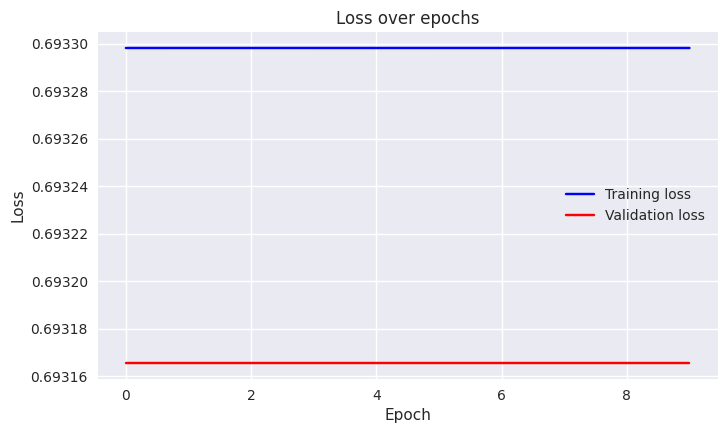

In [442]:
DISCOVERY_EPOCHS = 1
N_CLASSES = 2

clean_training_set, clean_test_set = get_datasets_for_discovery()

clean_discovery_results = []
for i in range(DISCOVERY_EPOCHS):
    clean_discovery_results.append(run_discovery(clean_training_set, clean_test_set, LeNet5(N_CLASSES)))

# print(clean_discovery_results)
# noisy_discovery_results = []
# for i in range(DISCOVERY_EPOCHS):
#     noisy_discovery_results.append(run_discovery(clean_training_dataset, noisy_test_dataset, LeNet5(N_CLASSES)))

# ae_powered_noisy_discovery_results = []
# for i in range(DISCOVERY_EPOCHS):
#     ae_powered_noisy_discovery_results.append(run_discovery(clean_training_dataset, noisy_test_dataset, LeNet5(N_CLASSES), ae=LeNet5AutoEncoder(latent_size=20))
    
# compare_discovery_results([clean_discovery_results, noisy_discovery_results, ae_powered_noisy_discovery_results])